# Cokriging from maximum likelihood estimates over continental US

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import krige_tools
import fields
import variogram as vgm
import cov_model
import cokrige

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [11]:
# Analysis variables
timestamp = "2019-08-01"
timedelta = -1

In [12]:
# Get data: 5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_4x5deg_monthly_conus.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

# Todo: make keywords a dict
mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, standardize_window=True, fast_dist=True)

../src/krige_tools.py:101: RuntimeWarning: Mean of empty slice
  custom_std = lambda x: np.sqrt(np.nanmean(x ** 2, axis=-1))
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
../src/krige_tools.py:101: RuntimeWarning: Mean of empty slice
  custom_std = lambda x: np.sqrt(np.nanmean(x ** 2, axis=-1))
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


### Standardized residuals still have a seasonal component

Non-zero spatial mean at each time index needs to be removed

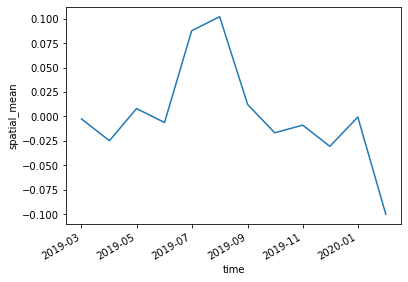

In [72]:
mf.field_1.ds["spatial_mean"].plot()

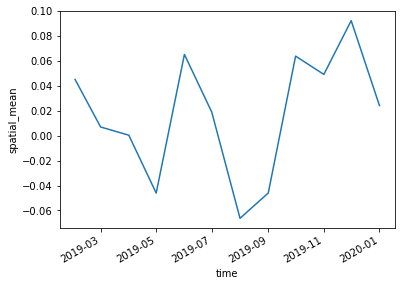

In [73]:
mf.field_2.ds["spatial_mean"].plot()

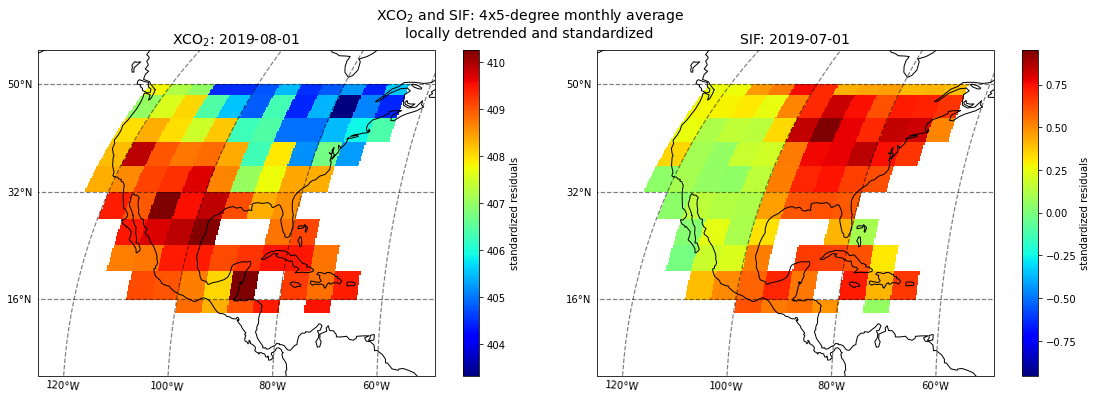

In [11]:
# Plot the data being used for cokriging
# NOTE: figures should share a color bar, but we just want a quick look
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(100, 100)
# cbar_ax = fig.add_subplot(gs[:, 98:])
extents = [-125, -60, 5, 52]

fig.suptitle(
    "XCO$_2$ and SIF: 4x5-degree monthly average\n"+
    "locally detrended and standardized", 
    size=14, # y=0.98
)

# Input data
ax1 = fig.add_subplot(gs[:, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:, 50:], projection=ccrs.EqualEarth())

xr.plot.imshow(
        darray=mf.field_1.to_xarray()["values"].T,
        transform=ccrs.PlateCarree(),
        ax=ax1,
        cmap="jet",
#         vmin=-2,
#         center=0,
#         cbar_ax=None,
        cbar_kwargs={"label": "standardized residuals"},
    )
ax1.coastlines()
ax1.set_extent(extents)
ax1.set_title(f"XCO$_2$: {mf.field_1.timestamp}", fontsize=14)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=1.2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl1.top_labels = False
gl1.left_labels = True
gl1.right_labels = False
gl1.xlines = True
gl1.ylines = True
gl1.xlocator = mticker.FixedLocator([-120, -100, -80, -60])
gl1.ylocator = mticker.FixedLocator([16, 32, 50])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER

xr.plot.imshow(
        darray=mf.field_2.to_xarray()["values"].T,
        transform=ccrs.PlateCarree(),
        ax=ax2,
        cmap="jet",
#         vmin=-2,
#         center=0,
#         cbar_ax=cbar_ax,
        cbar_kwargs={"label": "standardized residuals"},
    )
ax2.coastlines()
ax2.set_extent(extents)
ax2.set_title(f"SIF: {mf.field_2.timestamp}", fontsize=14)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), linewidth=1.2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl2.top_labels = False
gl2.left_labels = True
gl2.right_labels = False
gl2.xlines = True
gl2.ylines = True
gl2.xlocator = mticker.FixedLocator([-120, -100, -80, -60])
gl2.ylocator = mticker.FixedLocator([16, 32, 50])
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER

# fig.savefig("../plots/standardized_residuals_conus_4x5.png");

## Removing the spatial mean

### Mean

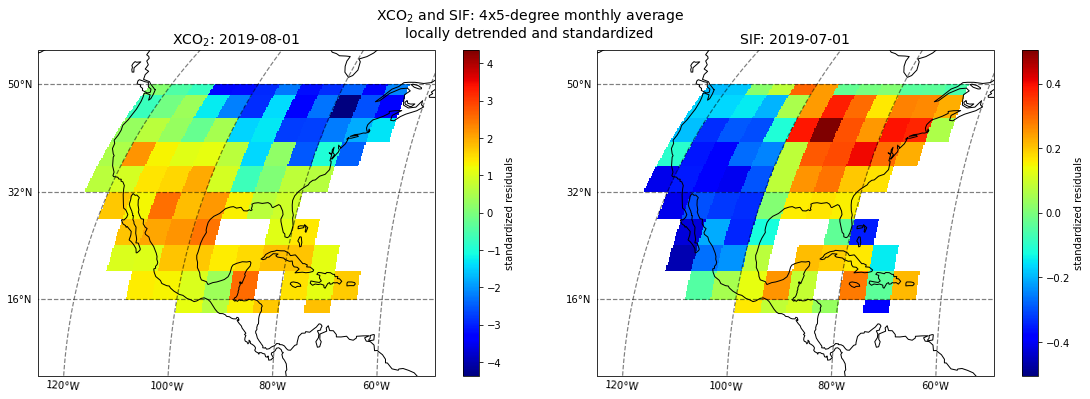

In [12]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(100, 100)
# cbar_ax = fig.add_subplot(gs[:, 98:])
extents = [-125, -60, 5, 52]

fig.suptitle(
    "XCO$_2$ and SIF: 4x5-degree monthly average\n"+
    "locally detrended and standardized", 
    size=14, # y=0.98
)

# Input data
ax1 = fig.add_subplot(gs[:, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:, 50:], projection=ccrs.EqualEarth())

mu1 = mf.field_1.to_xarray()["values"].mean()
xr.plot.imshow(
        darray=mf.field_1.to_xarray()["values"].T - mu1,
        transform=ccrs.PlateCarree(),
        ax=ax1,
        cmap="jet",
#         vmin=-2,
#         center=0,
#         cbar_ax=None,
        cbar_kwargs={"label": "standardized residuals"},
    )
ax1.coastlines()
ax1.set_extent(extents)
ax1.set_title(f"XCO$_2$: {mf.field_1.timestamp}", fontsize=14)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=1.2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl1.top_labels = False
gl1.left_labels = True
gl1.right_labels = False
gl1.xlines = True
gl1.ylines = True
gl1.xlocator = mticker.FixedLocator([-120, -100, -80, -60])
gl1.ylocator = mticker.FixedLocator([16, 32, 50])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER

mu2 = mf.field_2.to_xarray()["values"].mean()
xr.plot.imshow(
        darray=mf.field_2.to_xarray()["values"].T - mu2,
        transform=ccrs.PlateCarree(),
        ax=ax2,
        cmap="jet",
#         vmin=-2,
#         center=0,
#         cbar_ax=cbar_ax,
        cbar_kwargs={"label": "standardized residuals"},
    )
ax2.coastlines()
ax2.set_extent(extents)
ax2.set_title(f"SIF: {mf.field_2.timestamp}", fontsize=14)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), linewidth=1.2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl2.top_labels = False
gl2.left_labels = True
gl2.right_labels = False
gl2.xlines = True
gl2.ylines = True
gl2.xlocator = mticker.FixedLocator([-120, -100, -80, -60])
gl2.ylocator = mticker.FixedLocator([16, 32, 50])
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER

### Median

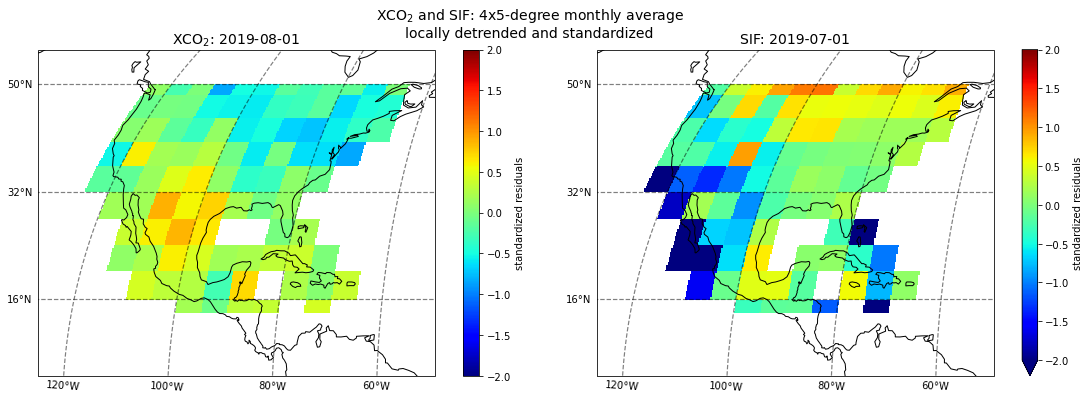

In [11]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(100, 100)
# cbar_ax = fig.add_subplot(gs[:, 98:])
extents = [-125, -60, 5, 52]

fig.suptitle(
    "XCO$_2$ and SIF: 4x5-degree monthly average\n"+
    "locally detrended and standardized", 
    size=14, # y=0.98
)

# Input data
ax1 = fig.add_subplot(gs[:, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:, 50:], projection=ccrs.EqualEarth())

mu1 = mf.field_1.to_xarray()["values"].median()
xr.plot.imshow(
        darray=mf.field_1.to_xarray()["values"].T - mu1,
        transform=ccrs.PlateCarree(),
        ax=ax1,
        cmap="jet",
        vmin=-2,
        center=0,
#         cbar_ax=None,
        cbar_kwargs={"label": "standardized residuals"},
    )
ax1.coastlines()
ax1.set_extent(extents)
ax1.set_title(f"XCO$_2$: {mf.field_1.timestamp}", fontsize=14)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=1.2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl1.top_labels = False
gl1.left_labels = True
gl1.right_labels = False
gl1.xlines = True
gl1.ylines = True
gl1.xlocator = mticker.FixedLocator([-120, -100, -80, -60])
gl1.ylocator = mticker.FixedLocator([16, 32, 50])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER

mu2 = mf.field_2.to_xarray()["values"].median()
xr.plot.imshow(
        darray=mf.field_2.to_xarray()["values"].T - mu2,
        transform=ccrs.PlateCarree(),
        ax=ax2,
        cmap="jet",
        vmin=-2,
        center=0,
#         cbar_ax=cbar_ax,
        cbar_kwargs={"label": "standardized residuals"},
    )
ax2.coastlines()
ax2.set_extent(extents)
ax2.set_title(f"SIF: {mf.field_2.timestamp}", fontsize=14)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), linewidth=1.2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl2.top_labels = False
gl2.left_labels = True
gl2.right_labels = False
gl2.xlines = True
gl2.ylines = True
gl2.xlocator = mticker.FixedLocator([-120, -100, -80, -60])
gl2.ylocator = mticker.FixedLocator([16, 32, 50])
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER

### Linear model

Modeling the mean would take us out of the realm of simple kriging. Let's try the easy way first and then come back to this.

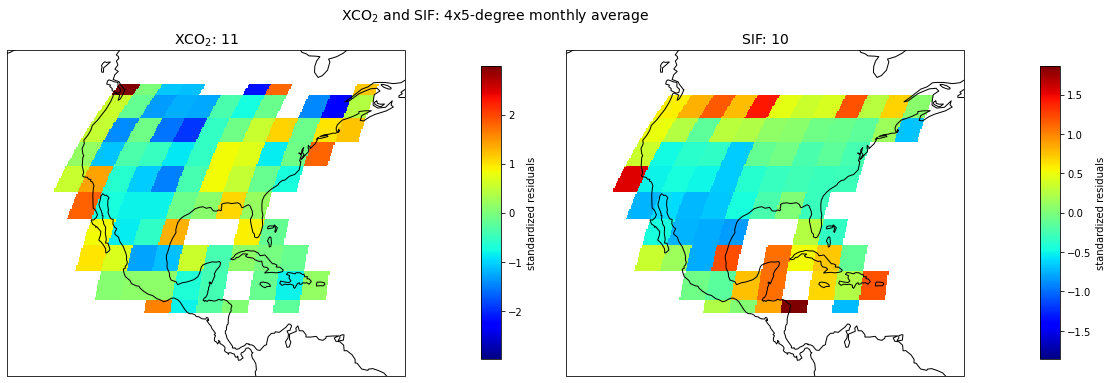

In [17]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(100, 100)
extents = [-125, -60, 5, 52]

ax1 = fig.add_subplot(gs[:, 0:45], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:, 50:95], projection=ccrs.EqualEarth())
cbar1 = fig.add_subplot(gs[5:95, 47:49])
cbar2 = fig.add_subplot(gs[5:95, 97:99])
    
fig.suptitle(
    "XCO$_2$ and SIF: 4x5-degree monthly average\n", 
    size=14, # y=0.98
)

def animate(month):
    """Update contour with new frame (each frame should be a monthly group)"""
    ax1.clear()
    ax2.clear()
    cbar1.clear()
    cbar2.clear()
    
    da_xco2 = mf.field_1.ds.xco2.isel(time=month)
    da_sif = mf.field_2.ds.sif.isel(time=month-np.abs(timedelta))
    
    xr.plot.imshow(
            darray=da_xco2.T,
            transform=ccrs.PlateCarree(),
            ax=ax1,
            cmap="jet",
    #         vmin=-2,
    #         center=0,
            cbar_ax=cbar1,
            cbar_kwargs={"label": "standardized residuals"},
        )
    ax1.coastlines()
    ax1.set_extent(extents)
    ax1.set_title(f"XCO$_2$: {month}", fontsize=14)

    xr.plot.imshow(
            darray=da_sif.T,
            transform=ccrs.PlateCarree(),
            ax=ax2,
            cmap="jet",
    #         vmin=-2,
    #         center=0,
            cbar_ax=cbar2,
            cbar_kwargs={"label": "standardized residuals"},
        )
    ax2.coastlines()
    ax2.set_extent(extents)
    ax2.set_title(f"SIF: {month-np.abs(timedelta)}", fontsize=14)
   
    

mov = FuncAnimation(fig, animate, frames=mf.field_1.ds.time.size, 
                    interval=500)

HTML(mov.to_html5_video())
mov.save(f"../plots/4x5degree_monthly_avg_about_{timestamp}.mp4", fps=2, dpi=250)

## What do variogram models look like?

<AxesSubplot:xlabel='distance'>

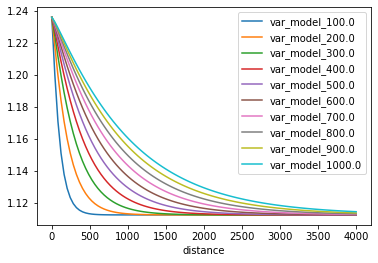

In [118]:
pred = np.linspace(0, 4e3, 100)
sigmas = np.linspace(0.2, 1.2, 8)
smoothnesses = np.linspace(0.2, 4.5, 8)
len_scales = np.linspace(100, 1e3, 10)
nuggets = np.linspace(0.0, 1.0, 8)
rhos = np.linspace(-1.0, -0.1, 8)


df_var = pd.DataFrame({"distance": pred})
# for sig in sigmas:
#     df_var[f"var_model_{sig}"] = vgm.matern_vario(pred, sig, 2.5, 2e3, 0.0)
# for nu in smoothnesses:
#     df_var[f"var_model_{nu}"] = vgm.matern_vario(pred, 0.9, nu, 750, 0.3)
# for len_scale in len_scales:
#     df_var[f"var_model_{len_scale}"] = vgm.matern_vario(pred, 1.0, 0.3, len_scale, 0.0)
# for nugget in nuggets:
#     df_var[f"var_model_{nugget}"] = vgm.matern_vario(pred, 1.0, 0.3, 5e3, nugget)
# for nu in smoothnesses:
#     df_var[f"var_model_{nu}"] = vgm.matern_cross_vario(pred, [0.7, 0.9], [0.6, 0.3], nu, 1e3, -0.2)
for len_scale in len_scales:
    df_var[f"var_model_{len_scale}"] = vgm.matern_cross_vario(pred, [0.65, 0.95], [0.6, 0.3], 0.6, len_scale, -0.2)
# for rho in rhos:
#     df_var[f"var_model_{rho}"] = vgm.matern_cross_vario(pred, [0.6, 0.9], [0.6, 0.3], 0.5, 500, rho)


df_var.plot(x="distance")

<AxesSubplot:xlabel='distance'>

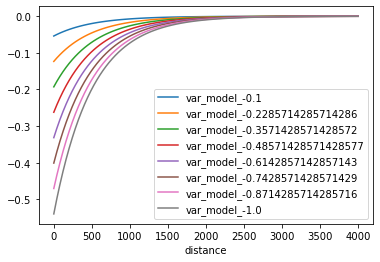

In [95]:
pred = np.linspace(0, 4e3, 100)
sigmas = np.linspace(0.2, 1.2, 8)
smoothnesses = np.linspace(0.2, 4.5, 8)
len_scales = np.linspace(5e2, 5e3, 10)
nuggets = np.linspace(0.0, 1.0, 8)
rhos = np.linspace(-0.1, -1, 8)


df_cov = pd.DataFrame({"distance": pred})
# for sig in sigmas:
#     df_cov[f"var_model_{sig}"] = vgm.matern_cov(pred, sig, 2.5, 750, 0.0)
# for nu in smoothnesses:
#     df_cov[f"var_model_{nu}"] = vgm.matern_cov(pred, 0.9, nu, 750, 0.3)
# for len_scale in len_scales:
#     df_cov[f"var_model_{len_scale}"] = vgm.matern_cov(pred, 1.0, 0.3, len_scale, 0.0)
# for nugget in nuggets:
#     df_cov[f"var_model_{nugget}"] = vgm.matern_cov(pred, 1.0, 0.3, 5e3, nugget)
# for nu in smoothnesses:
#     df_cov[f"var_model_{nu}"] = vgm.matern_cross_cov(pred, [0.42, 0.64], [0.07, 0.14], nu, 2e3, -0.8)
for len_scale in len_scales:
    df_cov[f"var_model_{len_scale}"] = vgm.matern_cross_cov(pred, [0.42, 0.64], [0.07, 0.14], 1.5, len_scale, -0.8)
# for rho in rhos:
#     df_cov[f"var_model_{rho}"] = vgm.matern_cross_cov(pred, [0.6, 0.9], 0.5, 500, rho)


df_cov.plot(x="distance")

Current problem with fitting cross-variogram is that sigmas are too small.

[0.04166446]


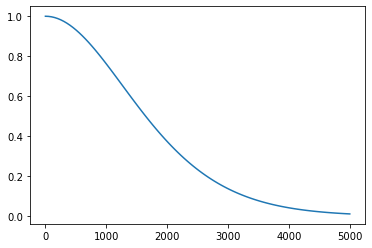

In [87]:
# How long does it take correlation to drop to zero with the parameters we're seeing?
print(vgm.matern_correlation(np.array([4e3]), 4.5, 1500))
pred = np.linspace(0, 5e3, 100)
corr = vgm.matern_correlation(pred, 4.5, 1500)
plt.plot(pred, corr)

## Empirical variograms

In [6]:
# Variogram settings
# bin_centers = np.linspace(0, 6e3, 20)
# tol = 250
n_bins = 14

# Initial guess for covariance params
cov_guesses = [[0.6, 1.5, 500, 0.6], [1.0, 2.5, 500, 0.3]]
cross_guess = [0.2, 1e3, -0.8]

In [13]:
k1 = cov_model.Matern()
k2 = cov_model.Matern()
model = cov_model.BivariateMatern(mf, k1, k2)
vario_res, covario_res, params = model.empirical_variograms(cov_guesses, cross_guess, n_bins=n_bins, shift_coords=True)
# predictor = cokrige.Cokrige(mf, model, fast_dist=True)

lags = vario_res["xco2"]["lag"].values
bin_width = lags[2] - lags[1]

xco2
sif
xco2:sif


In [13]:
names = [mf.field_1.data_name, "", mf.field_2.data_name]
names[1] = f"{names[0]}:{names[2]}"

guess = np.hstack([params[name] for name in names])
guess

array([ 3.05936785e-01,  3.46426342e+04,  4.00000000e-01,  9.99999514e+03,
       -7.37386855e-01,  2.24377763e-01,  7.73372956e+03])

In [13]:
# guess = list(model.get_params().values())
# guess[3] = 1600.0
# guess[4] = -0.7
# guess = [2.2, 1700.0, 0.1, 500.0, -0.6, 0.4, 1200.0, 0.1]
model.fit(initial_guess=guess)

print(model.get_params())
mle_params = list(model.get_params().values())
mle_params

In [15]:
vario_res["xco2"]["mle_fit"] = vgm.matern_cov(vario_res["xco2"]["lag"], *mle_params[:4])
vario_res["xco2:sif"]["mle_fit"] = vgm.matern_cross_cov(vario_res["xco2:sif"]["lag"], [mle_params[0], mle_params[7]], *mle_params[4:7])
vario_res["sif"]["mle_fit"] = vgm.matern_cov(vario_res["sif"]["lag"], *mle_params[7:])

In [8]:
def param_labels(params, cross=False):
    p = np.round_(params, decimals=3)
    if cross:
        return f"nu: {p[0]}\nlen_scale: {p[1]}\nrho: {p[2]}"
    else:
        return f"sigma: {p[0]}\n nu: {p[1]}\n len_scale: {p[2]}\n nugget: {p[3]}"

Text(0.5, 0.98, 'Semivariograms and cross-semivariogram for XCO$_2$ and SIF residuals\n4x5-degree continental US, 2019-08-01, locally detrended and standardized, bin width 229 km')

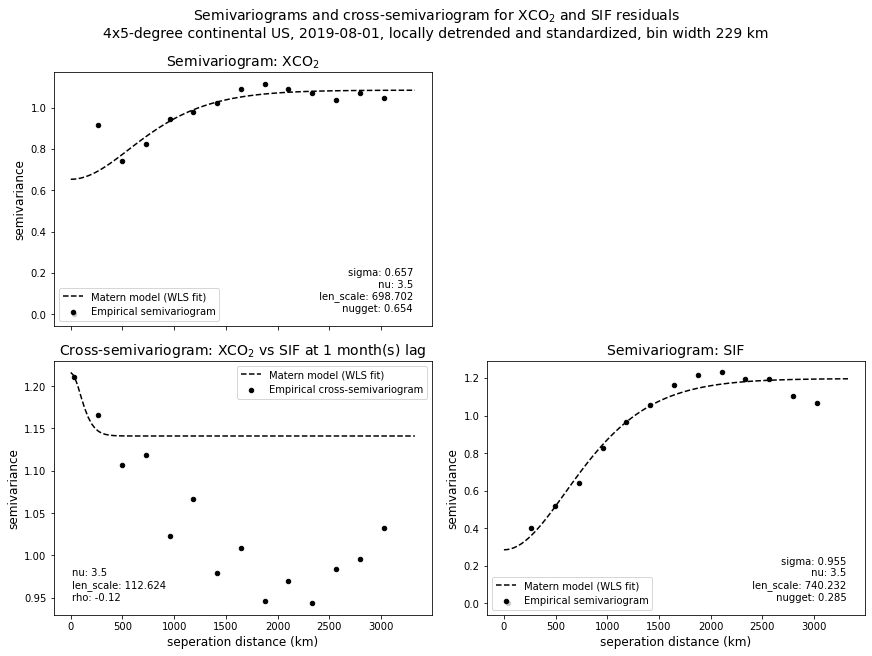

In [14]:
var_names = ["xco2", "sif"]
cross_name = "xco2:sif"

fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")
            
for i, var in enumerate(var_names):
    df = vario_res[var]
    df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
    df.plot(x="lag", y=var, kind="scatter", color="black", ax=ax[i, i], label="Empirical semivariogram")
    ax[i, i].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].set_title(var, fontsize=12)
    ax[i, i].set_ylabel("semivariance", fontsize=12)
    ax[i, i].set_xlabel("seperation distance (km)", fontsize=12)
    ax[i, i].text(0.95, 0.05, param_labels(params[var]), transform=ax[i, i].transAxes, ha="right", va="bottom")
    ax[i, i].legend(loc="lower left")

df = vario_res[cross_name]
df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
df.plot(x="lag", y="xco2:sif", kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross-semivariogram")
ax[1, 0].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].text(0.05, 0.05, param_labels(params[cross_name], cross=True), transform=ax[1, 0].transAxes, ha="left", va="bottom")
ax[1, 0].legend(loc="upper right")
ax[1, 0].set_ylabel("semivariance", fontsize=12)
ax[1, 0].set_xlabel("seperation distance (km)", fontsize=12)

ax[0, 0].set_title("Semivariogram: XCO$_2$", fontsize=14)
ax[1, 0].set_title(f"Cross-semivariogram: XCO$_2$ vs SIF at {np.abs(timedelta)} month(s) lag", fontsize=14)
ax[1, 1].set_title("Semivariogram: SIF", fontsize=14)

fig.suptitle("Semivariograms and cross-semivariogram for XCO$_2$ and SIF residuals\n"+
            f"4x5-degree continental US, {timestamp}, locally detrended and standardized, bin width {np.int(bin_width)} km", fontsize=14)

# fig.savefig(f"../plots/semivariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag.png", dpi=100)

Text(0.5, 0.98, 'Covariograms and cross-covariogram for XCO$_2$ and SIF residuals\n4x5-degree continental US, 2019-08-01, locally detrended and standardized, bin width 229 km')

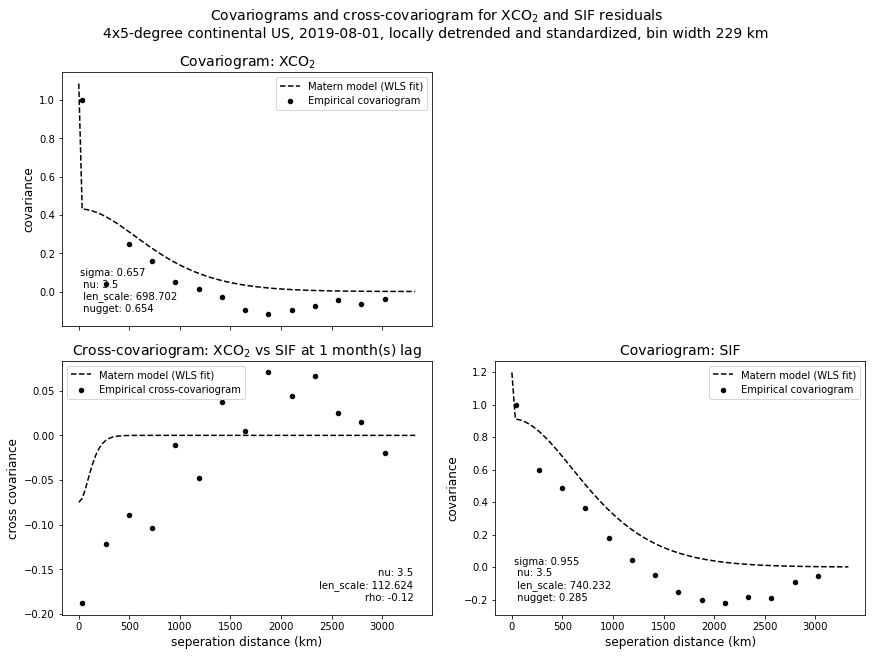

In [15]:
var_names = ["xco2", "sif"]
cross_name = "xco2:sif"

fig, ax = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True, sharex=True)
ax[0, 1].axis("off")
            
for i, var in enumerate(var_names):
    df = covario_res[var]
    df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
    df.plot(x="lag", y=var, kind="scatter", color="black", ax=ax[i, i], label="Empirical covariogram")
    ax[i, i].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
    ax[i, i].set_title(var, fontsize=12)
    ax[i, i].set_ylabel("covariance", fontsize=12)
    ax[i, i].set_xlabel("seperation distance (km)", fontsize=12)
    ax[i, i].text(0.05, 0.05, param_labels(params[var]), transform=ax[i, i].transAxes, ha="left", va="bottom")
    ax[i, i].legend()

df = covario_res[cross_name]
df_fit = df.dropna(subset=["wls_fit"]).sort_values("lag")
df.plot(x="lag", y="xco2:sif", kind="scatter", color="black", ax=ax[1, 0], label="Empirical cross-covariogram")
ax[1, 0].plot(df_fit["lag"], df_fit["wls_fit"], linestyle="--", color="black", label="Matern model (WLS fit)")
ax[1, 0].text(0.95, 0.05, param_labels(params[cross_name], cross=True), transform=ax[1, 0].transAxes, ha="right", va="bottom")
ax[1, 0].legend(loc="upper left")
ax[1, 0].set_ylabel("cross covariance", fontsize=12)
ax[1, 0].set_xlabel("seperation distance (km)", fontsize=12)

ax[0, 0].set_title("Covariogram: XCO$_2$", fontsize=14)
ax[1, 0].set_title(f"Cross-covariogram: XCO$_2$ vs SIF at {np.abs(timedelta)} month(s) lag", fontsize=14)
ax[1, 1].set_title("Covariogram: SIF", fontsize=14)

fig.suptitle("Covariograms and cross-covariogram for XCO$_2$ and SIF residuals\n"+
            f"4x5-degree continental US, {timestamp}, locally detrended and standardized, bin width {np.int(bin_width)} km", fontsize=14)

# fig.savefig(f"../plots/covariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag.png", dpi=100)

Fitting summary: 
- Larger nu's work better for variograms, but covariogram models look better with nu's < 1

## Alternative formulation

In [78]:
df_1 = covario_res["xco2"].dropna(subset=["counts"])
df_2 = covario_res["sif"].dropna(subset=["counts"])
df_12 = covario_res["xco2:sif"].dropna(subset=["counts"])

c1 = df_1["xco2"][df_temp["lag"] == df_temp["lag"].min()].values[0]
c2 = df_2["sif"][df_temp["lag"] == df_temp["lag"].min()].values[0]

In [79]:
var_xco2 = np.zeros(df_1["xco2"].size)
for i, var in enumerate(df_1["xco2"]):
    var_xco2[i] = c1 - var
    
df_1["var_xco2"] = var_xco2

var_sif = np.zeros(df_2["sif"].size)
for i, var in enumerate(df_2["sif"]):
    var_sif[i] = c2 - var
    
df_2["var_sif"] = var_sif

var_cross = np.zeros(df_12["xco2:sif"].size)
for i, var in enumerate(df_12["xco2:sif"]):
    var_cross[i] = 0.5*(c1 + c2) - var
    
df_12["var_cross"] = var_cross

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

<AxesSubplot:xlabel='lag', ylabel='var_cross'>

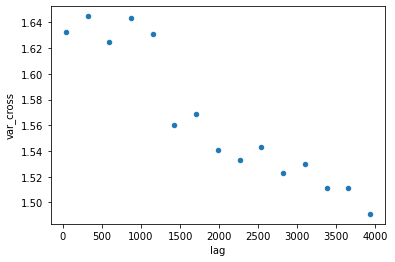

In [80]:
# Empirical cross-variogram
df_12.plot.scatter(x="lag", y="var_cross")

## Maximum Likelihood

With or without the addition of the measurement error along the covariance matrix diagional, MLE wants to push up sigma_11 and drive down sigma_22. This makes it hard to get good estimates for any other parameters and yeilds a very poor cross-covariance model (with respect to the empirical cross covariogram).